## Exploratory Data Analysis

In [1]:
!pip install sqlalchemy
!pip install pyhive
!pip install thrift
!pip install sasl
!pip install thrift-sasl 
!pip install psycopg2-binary
!pip install pandas plotnine

import sqlalchemy
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 500)

# matplotlib and seaborn for plotting
import matplotlib
matplotlib.rcParams['figure.dpi'] = 120 #resolution
matplotlib.rcParams['figure.figsize'] = (8,6) #figure size
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
color = sns.color_palette()


## Data

In [2]:

sparkConn = sqlalchemy.create_engine('hive://spark-thrift:10000/default')
pd.read_sql_query("use sample", con=sparkConn)
pd.read_sql_query("show tables", con=sparkConn)

,database,tableName,isTemporary
0,sample,avg_product_count_by_dow,False
1,sample,clean_orders,False
2,sample,daily_orders,False
3,sample,daily_orders_7_day_avg,False
4,sample,order_products,False
5,sample,order_products_union,False
6,sample,product_count,False
7,sample,stg_top_selling_products,False
8,sample,top_selling_aisles,False
9,sample,top_selling_departments,False


In [4]:
# limit the data to 1M rows for avoid OFME
order_products = pd.read_sql_query("select * from sample.order_products limit 1000000", con=sparkConn)



Checking above dataframes

In [5]:
order_products.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,...,product_name,aisle_id,aisle,department_id,department
0,347,1158,14,True,17155,...,Mango Chunks,116.0,frozen produce,1.0,frozen
1,347,17304,12,True,17155,...,Powdered Peanut Butter,88.0,spreads,13.0,pantry
2,347,17948,13,True,17155,...,Frozen Organic Wild Blueberries,116.0,frozen produce,1.0,frozen
3,347,18689,7,True,17155,...,Dairy-Free Chive Cream Cheese,108.0,other creams cheeses,16.0,dairy eggs
4,347,21903,5,True,17155,...,Organic Baby Spinach,123.0,packaged vegetables fruits,4.0,produce


In [6]:
order_products.tail()

,order_id,product_id,add_to_cart_order,reordered,user_id,...,product_name,aisle_id,aisle,department_id,department
999995,2747577,47626,2,False,151843,...,Large Lemon,24.0,fresh fruits,4.0,produce
999996,2747577,49683,13,True,151843,...,Cucumber Kirby,83.0,fresh vegetables,4.0,produce
999997,2747950,11520,4,True,205369,...,Large Alfresco Eggs,86.0,eggs,16.0,dairy eggs
999998,2747950,16387,3,False,205369,...,Cold-Pressed Organic Grapefruit,98.0,juice nectars,7.0,beverages
999999,2747950,16759,5,False,205369,...,Organic Carrot Bunch,83.0,fresh vegetables,4.0,produce


In [7]:
order_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 16 columns):
 #   Column                      Non-Null Count    Dtype         
---  ------                      --------------    -----         
 0   order_id                    1000000 non-null  int64         
 1   product_id                  1000000 non-null  int64         
 2   add_to_cart_order           1000000 non-null  int64         
 3   reordered                   1000000 non-null  bool          
 4   user_id                     1000000 non-null  int64         
 5   order_number                1000000 non-null  int64         
 6   order_dow                   1000000 non-null  int64         
 7   order_hour_of_day           1000000 non-null  int64         
 8   days_since_prior_order      939056 non-null   float64       
 9   days_since_prior_order_cum  1000000 non-null  float64       
 10  order_date                  1000000 non-null  datetime64[ns]
 11  product_name             

## Data preparation

For Analysis, I am combining order_products_train and order_products_prior as order_products. Based on order_id, product_id, aisle_id and department_id I will merge those data with order_products and will create one single dataframe.

#### Reducing memory usage for faster analysis

In [8]:
def reduce_memory(df):
    
    """
    This function reduce the dataframe memory usage by converting it's type for easier handling.
    
    Parameters: Dataframe
    Return: Dataframe
    """
    
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    
    for col in df.columns:
        if df[col].dtypes in ["int64", "int32", "int16"]:
            
            cmin = df[col].min()
            cmax = df[col].max()
            
            if cmin > np.iinfo(np.int8).min and cmax < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            
            elif cmin > np.iinfo(np.int16).min and cmax < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            
            elif cmin > np.iinfo(np.int32).min and cmax < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
        
        if df[col].dtypes in ["float64", "float32"]:
            
            cmin = df[col].min()
            cmax = df[col].max()
            
            if cmin > np.finfo(np.float16).min and cmax < np.finfo(np.float16).max:
                df[col] = df[col].astype(np.float16)
            
            elif cmin > np.finfo(np.float32).min and cmax < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
    
    print("")
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    
    return df

In [9]:
order_products = reduce_memory(order_products)

Memory usage of properties dataframe is : 115.39471435546875  MB

___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  55.313232421875  MB
This is  47.933939375667435 % of the initial size


#### list all variables

In [10]:
%whos

Variable         Type             Data/Info
-------------------------------------------
color            _ColorPalette    [(0.12156862745098039, 0.<...>863, 0.8117647058823529)]
matplotlib       module           <module 'matplotlib' from<...>/matplotlib/__init__.py'>
np               module           <module 'numpy' from '/op<...>kages/numpy/__init__.py'>
order_products   DataFrame                order_id  product<...>000000 rows x 16 columns]
pd               module           <module 'pandas' from '/o<...>ages/pandas/__init__.py'>
plt              module           <module 'matplotlib.pyplo<...>es/matplotlib/pyplot.py'>
reduce_memory    function         <function reduce_memory at 0x7fe82dcd6a70>
sns              module           <module 'seaborn' from '/<...>ges/seaborn/__init__.py'>
sparkConn        Engine           Engine(hive://spark-thrift:10000/default)
sqlalchemy       module           <module 'sqlalchemy' from<...>/sqlalchemy/__init__.py'>


## Analysis

In [11]:
order_products.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,...,product_name,aisle_id,aisle,department_id,department
0,347,1158,14,True,17155,...,Mango Chunks,116.0,frozen produce,1.0,frozen
1,347,17304,12,True,17155,...,Powdered Peanut Butter,88.0,spreads,13.0,pantry
2,347,17948,13,True,17155,...,Frozen Organic Wild Blueberries,116.0,frozen produce,1.0,frozen
3,347,18689,7,True,17155,...,Dairy-Free Chive Cream Cheese,108.0,other creams cheeses,16.0,dairy eggs
4,347,21903,5,True,17155,...,Organic Baby Spinach,123.0,packaged vegetables fruits,4.0,produce


### Aisles

In [12]:
temp_df = order_products.groupby("aisle")["reordered"].agg(['count', 'sum']).rename(columns = {'count':'total','sum':'reorders'})
temp_df = temp_df.sort_values('total', ascending=False).reset_index()

#### Total Orders and Reorders From Most Popular Aisles

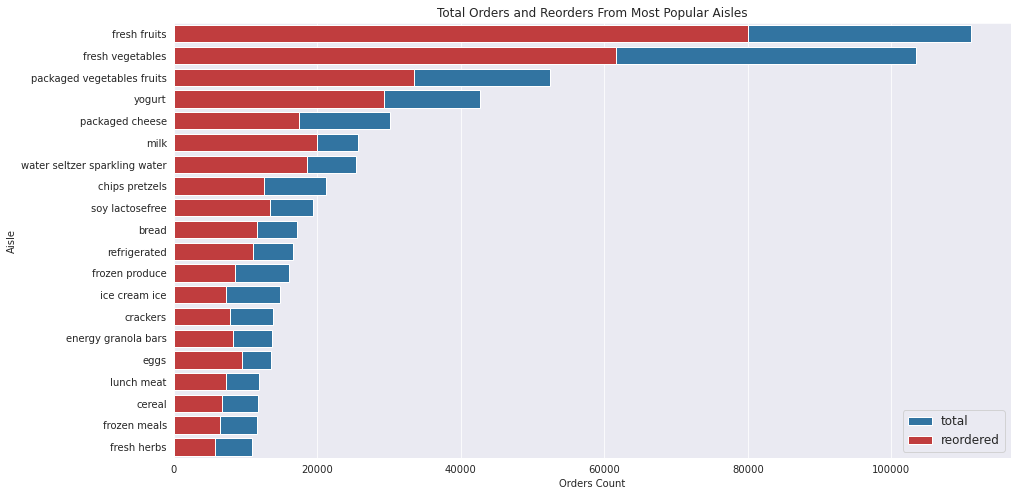

In [13]:
fig, ax = plt.subplots(figsize = (15,8))
ax = sns.barplot(y = temp_df.aisle[0:20], x = temp_df.total[0:20], color=color[0], label = "total")
ax = sns.barplot(y = temp_df.aisle[0:20], x = temp_df.reorders[0:20], color=color[3], label = "reordered")
ax.set_ylabel("Aisle")
ax.set_xlabel("Orders Count")
ax.set_title("Total Orders and Reorders From Most Popular Aisles")
ax.legend(loc = 4, prop={'size': 12})
plt.show()

In [14]:
temp_df["reorder_ratio"] = temp_df.reorders/temp_df.total
temp_df = temp_df.sort_values("reorder_ratio", ascending=False).reset_index()

#### 20 Aisles with Highest Reorder Ratio

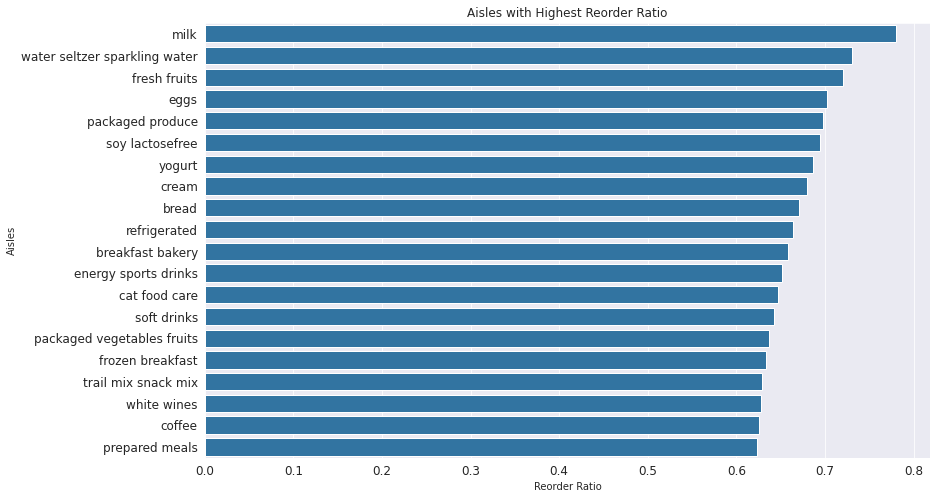

In [15]:
fig, ax = plt.subplots(figsize = (13,8))
ax = sns.barplot(y = temp_df.aisle[0:20], x = temp_df.reorder_ratio[0:20], color=color[0])
ax.set_ylabel("Aisles")
ax.set_xlabel("Reorder Ratio")
ax.set_title("Aisles with Highest Reorder Ratio")
ax.tick_params(axis = 'both', labelsize = 12)
plt.show()

#### 20 Aisles with Lowest Reorder Ratio

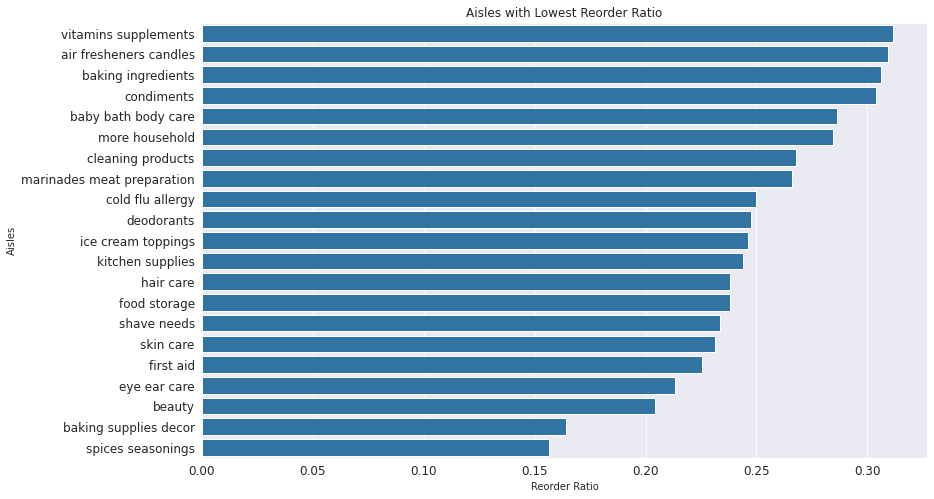

In [16]:
fig, ax = plt.subplots(figsize = (13,8))
ax = sns.barplot(y = temp_df.aisle[-21:], x = temp_df.reorder_ratio[-21:], color=color[0])
ax.set_ylabel("Aisles")
ax.set_xlabel("Reorder Ratio")
ax.set_title("Aisles with Lowest Reorder Ratio")
ax.tick_params(axis = 'both', labelsize = 12)
plt.show()

### Departments

In [17]:
temp_df = order_products.groupby("department")["reordered"].agg(['count', 'sum']).rename(columns = {'count':'total','sum':'reorders'})
temp_df = temp_df.sort_values('total', ascending=False).reset_index()

#### Total Orders and Reorders From Departments

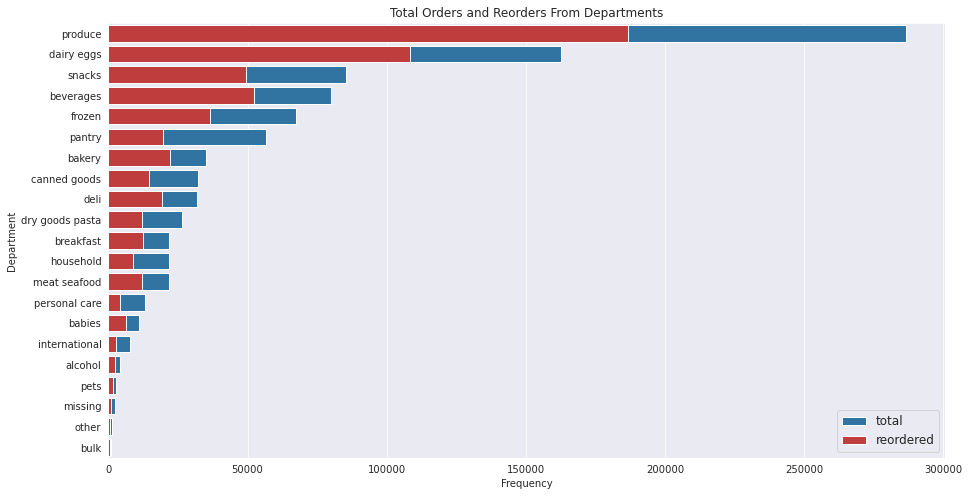

In [18]:
fig, ax = plt.subplots(figsize = (15,8))
ax = sns.barplot(y = temp_df.department, x = temp_df["total"], color=color[0], label = "total")
ax = sns.barplot(y = temp_df.department, x = temp_df["reorders"], color=color[3], label = "reordered")
ax.set_ylabel("Department")
ax.set_xlabel("Frequency")
ax.legend(loc = 4, prop={'size': 12})
ax.set_title("Total Orders and Reorders From Departments")
plt.show()

In [19]:
temp_df["reorder_ratio"] = temp_df.reorders/temp_df.total
temp_df = temp_df.sort_values("reorder_ratio", ascending=False).reset_index()

#### Departments with Highest Reorder Ratio

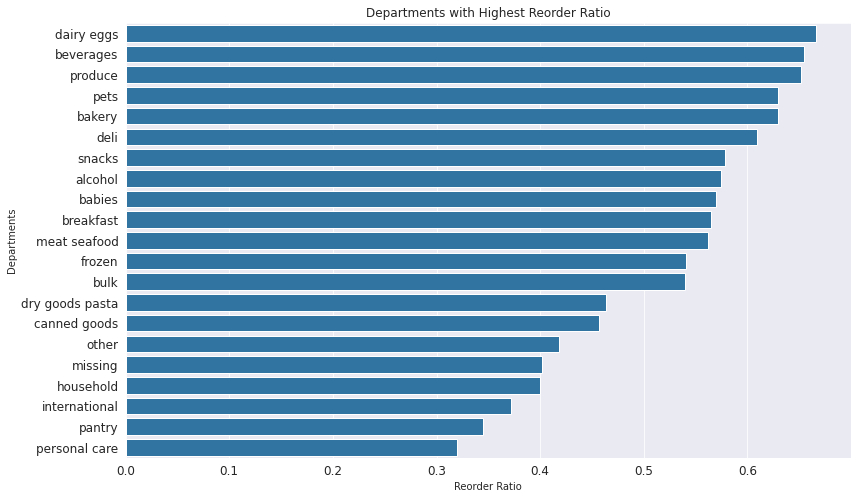

In [20]:
fig, ax = plt.subplots(figsize = (13,8))
ax = sns.barplot(y = temp_df.department, x = temp_df.reorder_ratio, color=color[0])
ax.set_ylabel("Departments")
ax.set_xlabel("Reorder Ratio")
ax.set_title("Departments with Highest Reorder Ratio")
ax.tick_params(axis = 'both', labelsize = 12)
plt.show()

### Products

In [21]:
temp_df = order_products.groupby("product_name")["reordered"].agg(['count', 'sum']).rename(columns = {'count':'total','sum':'reorders'})
temp_df = temp_df.sort_values('total', ascending=False).reset_index()

#### Most Popular Products

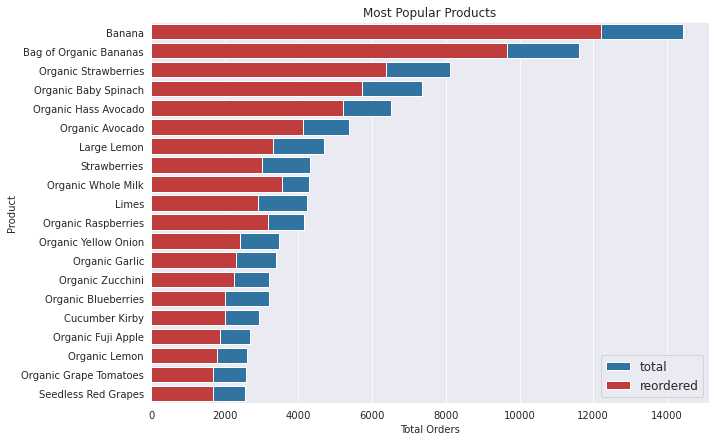

In [22]:
fig, ax = plt.subplots(figsize = (10,7))
ax = sns.barplot(y = temp_df.product_name[0:20], x = temp_df.total[0:20], color=color[0], label = "total")
ax = sns.barplot(y = temp_df.product_name[0:20], x = temp_df.reorders[0:20], color=color[3], label = "reordered")
ax.set_ylabel("Product")
ax.set_xlabel("Total Orders")
ax.set_title("Most Popular Products")
ax.legend(loc = 4, prop={'size': 12})
plt.show()

In [23]:
temp_df["reorder_ratio"] = temp_df.reorders/temp_df.total
temp_df.sort_values("reorder_ratio", ascending=False).head(10)

,product_name,total,reorders,reorder_ratio
34664,Smoked Turkey Slices,1,1,1.0
26491,Oregon Pinot Noir,2,2,1.0
26585,Whole Peeled Itaian Plum Tomatoes,1,1,1.0
26573,"""Pierogies",1,1,1.0
26570,Chipotle Burbon BBQ Sauce,1,1,1.0
26551,Classic Creme Cookies,1,1,1.0
26547,Alfredo Chicken,2,2,1.0
26539,Alexander Valley Cabernet Sauvignon Wine,2,2,1.0
26537,"""Quinoa Sticks",2,2,1.0
26535,Organic Vanilla Ice Cream & Dark Chocolate,2,2,1.0


#### Product Users

In [24]:
product_unique_users = order_products.groupby('product_name')['user_id'].nunique().reset_index().rename(columns={'user_id':'total_users'})
product_unique_users.sort_values('total_users', ascending = False).head(10)

,product_name,total_users
3894,Banana,11652
3759,Bag of Organic Bananas,9542
22845,Organic Strawberries,7013
20358,Organic Baby Spinach,6447
21540,Organic Hass Avocado,5563
20330,Organic Avocado,4712
16122,Large Lemon,4281
30223,Strawberries,3891
16824,Limes,3870
22398,Organic Raspberries,3576


In [25]:
product_unique_users = product_unique_users.merge(temp_df, on='product_name', how='left')
product_unique_users.sort_values("reorder_ratio", ascending=False).head(20)

,product_name,total_users,total,reorders,reorder_ratio
2580,Air Freshener Crisp Waters Spray,1,1,1,1.0
3217,Apple Cinnamon Scones,3,3,3,1.0
3225,Apple Fritters,2,2,2,1.0
24130,Oven Roasted Sliced Turkey Breast,1,1,1,1.0
30246,Strawberry Banana Fruit Sandwich Bar,3,3,3,1.0
3220,Apple Cinnamon Yogurt,1,1,1,1.0
5669,Candle Apple Cinnamon,1,1,1,1.0
3218,Apple Cinnamon Uncured Breakfast Sausage,3,4,4,1.0
10211,Dry Cola,2,2,2,1.0
3205,Apple Cinnamon Chia Squeeze Vitality Snack,2,2,2,1.0


#### Cumulative Sum of Unique Users Per Product

In [26]:
temp_df = product_unique_users.sort_values("total_users", ascending=False)
temp_df['cum_users'] = temp_df['total_users'].cumsum()
temp_df = temp_df.reset_index(drop=True)
temp_df.head()

,product_name,total_users,total,reorders,reorder_ratio,cum_users
0,Banana,11652,14424,12199,0.845743,11652
1,Bag of Organic Bananas,9542,11616,9666,0.832128,21194
2,Organic Strawberries,7013,8121,6384,0.786110,28207
3,Organic Baby Spinach,6447,7352,5724,0.778564,34654
4,Organic Hass Avocado,5563,6520,5220,0.800613,40217


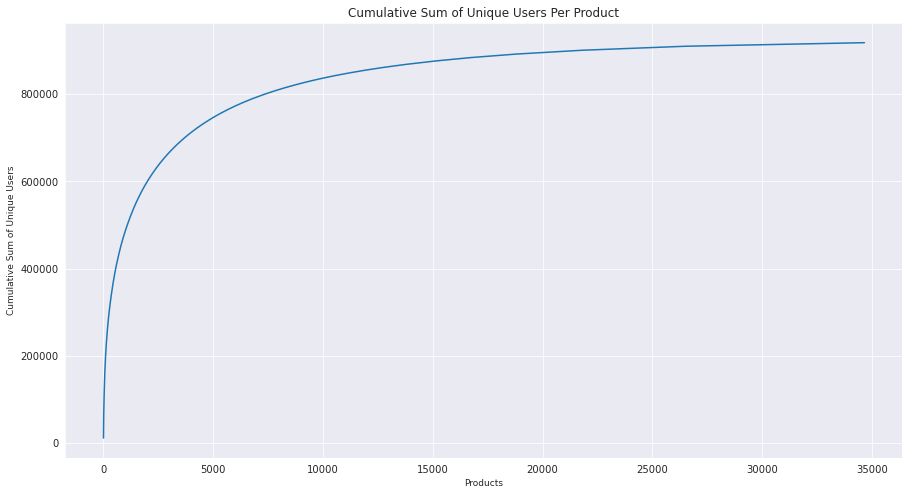

In [27]:
fig, ax = plt.subplots(figsize=(15,8))
ax = sns.lineplot(x = temp_df.index, y=temp_df.cum_users)
ax.set_xlabel("Products", size = 9)
ax.set_ylabel("Cumulative Sum of Unique Users", size = 9)
ax.set_title("Cumulative Sum of Unique Users Per Product", size = 12)
plt.show()

#### Total Product Orders VS Total Unique Product Buyers

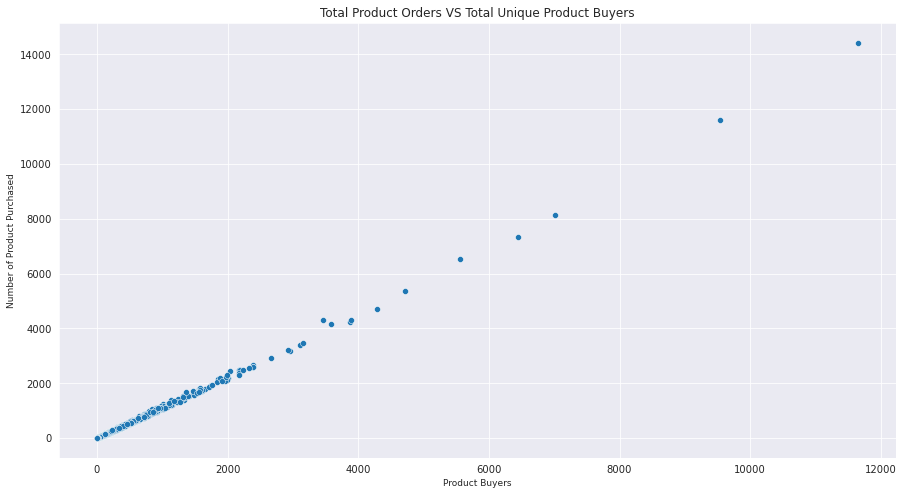

In [28]:
fig, ax = plt.subplots(figsize=(15,8))
ax = sns.scatterplot(y = product_unique_users.total, x = product_unique_users.total_users)
ax.set_xlabel("Product Buyers", size = 9)
ax.set_ylabel("Number of Product Purchased", size = 9)
ax.set_title("Total Product Orders VS Total Unique Product Buyers", size = 12)
plt.show()

#### Reorder Percentage VS Total Orders

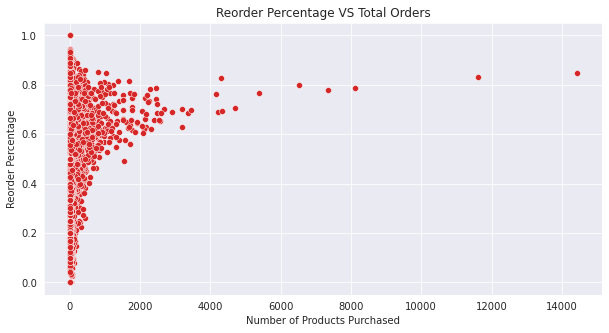

In [29]:
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.scatterplot(x = product_unique_users.total, y = product_unique_users.reorder_ratio, color = color[3])
ax.set_xlabel("Number of Products Purchased")
ax.set_ylabel("Reorder Percentage")
ax.set_title("Reorder Percentage VS Total Orders")
plt.show()

#### Reorder Percentage VS Total Unique Users

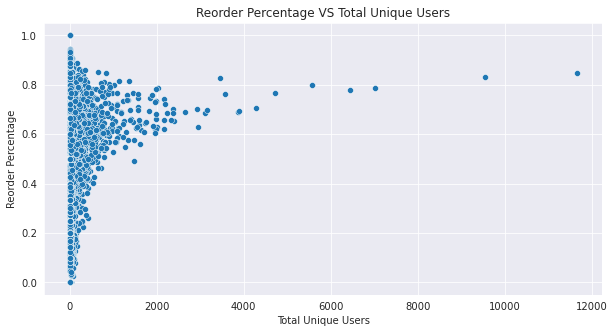

In [30]:
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.scatterplot(x = product_unique_users.total_users, y = product_unique_users.reorder_ratio, color = color[0])
ax.set_xlabel("Total Unique Users")
ax.set_ylabel("Reorder Percentage")
ax.set_title("Reorder Percentage VS Total Unique Users")
plt.show()

#### Organic Vs Inorganic

In [31]:
product_unique_users['Organic'] = product_unique_users.product_name.str.contains("Organic")
product_unique_users.head()

,product_name,total_users,total,reorders,reorder_ratio,Organic
0,"""0% Greek",38,43,30,0.697674,False
1,"""1",8,8,2,0.250000,False
2,"""1% Hydrocortisone Anti-Itch Cream",1,1,0,0.000000,False
3,"""1-to-1 Baking Flour",2,2,1,0.500000,False
4,"""10.25\"""" Elegant Fluted Party Plates""",2,3,3,1.000000,False


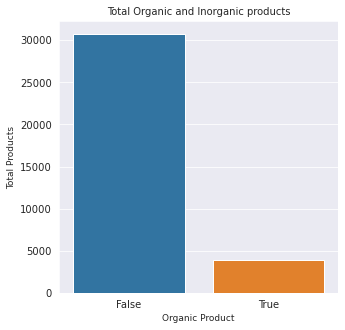

In [32]:
fig, ax = plt.subplots(figsize = (5,5))
ax = sns.barplot(x = product_unique_users.groupby('Organic').size().index, y = product_unique_users.groupby('Organic').size().values)
ax.set_xlabel("Organic Product", size = 9)
ax.set_ylabel("Total Products", size = 9)
ax.set_title("Total Organic and Inorganic products", size = 10)
plt.show()

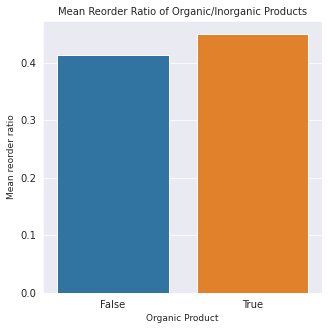

In [33]:
fig, ax = plt.subplots(figsize = (5,5))
ax = sns.barplot(x = product_unique_users.groupby('Organic')['reorder_ratio'].mean().index, y = product_unique_users.groupby('Organic')['reorder_ratio'].mean().values)
ax.set_xlabel("Organic Product", size = 9)
ax.set_ylabel("Mean reorder ratio", size = 9)
ax.set_title("Mean Reorder Ratio of Organic/Inorganic Products", size = 10)
plt.show()

#### Add to Cart Order VS Reorder  

In [34]:
temp_df = order_products.groupby('add_to_cart_order')['reordered'].mean().reset_index()
temp_df.head()

,add_to_cart_order,reordered
0,1,0.679391
1,2,0.675877
2,3,0.656472
3,4,0.637329
4,5,0.617961


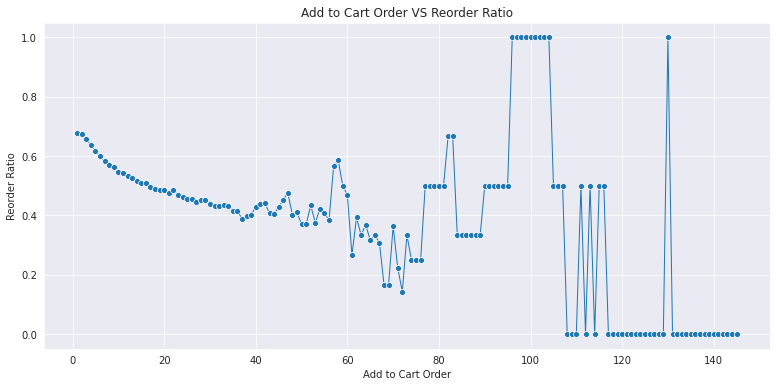

In [35]:
fig, ax = plt.subplots(figsize=(13,6))
ax = sns.lineplot(x=temp_df.add_to_cart_order, y=temp_df.reordered, lw = 1, marker='o')
ax.set_xlabel("Add to Cart Order")
ax.set_ylabel("Reorder Ratio")
ax.set_title("Add to Cart Order VS Reorder Ratio")
plt.show()

#### Most Popular Products on different days

In [36]:
temp_df = order_products.groupby(['order_dow', 'product_name']).size().reset_index(name='counts')
temp_df = temp_df.sort_values(['order_dow', 'counts'], ascending=[True, False])
temp_df = temp_df.groupby('order_dow').head(5).reset_index(drop = True)

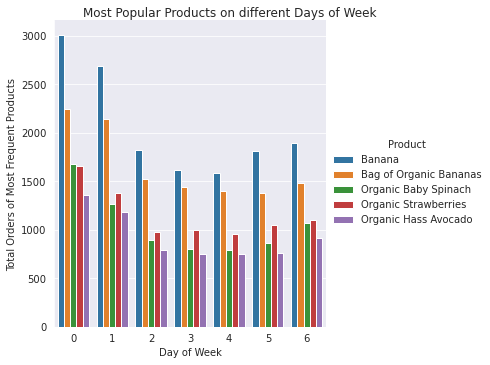

In [37]:
ax = sns.catplot(x="order_dow", y="counts", hue="product_name", data=temp_df, kind="bar", legend=False)
ax.add_legend(title="Product")
ax.set_axis_labels("Day of Week", "Total Orders of Most Frequent Products")
ax.fig.suptitle("Most Popular Products on different Days of Week", va="baseline", ha="center")
ax.savefig("./plot/Most Popular Products on Different Days of Week.png")

In [ ]:
sparkConn.connect().close()